In [51]:
import tensorflow as tf
import keras 
import pandas as pd
import numpy as np
from keras.callbacks import EarlyStopping
from keras import regularizers
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [52]:
demographics = pd.read_csv('test2.csv', low_memory=False)
demographics.head()

,Unnamed: 0,Unnamed: 0.1,SUBJECT_ID,GENDER,HADM_ID,DOB,DOD,DOA,ADMIT_AGE,ETHNICITY,...,HYPO_FLAG,SHOCK_FLAG,ANEMIA_FLAG,HEMO_FLAG,ACID_FLAG,LIVER_FLAG,HYPER_FLAG,CAUSE,VALUENUM,VALUE
0,0,0.0,31.0,M,128652.0,2036-05-17,2108-08-30 00:00:00,2108-08-22 23:27:00,72.312329,WHITE,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,STATUS EPILEPTICUS,0.9,NaN
1,1,0.0,31.0,M,128652.0,2036-05-17,2108-08-30 00:00:00,2108-08-22 23:27:00,72.312329,WHITE,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,STATUS EPILEPTICUS,0.7,NaN
2,2,0.0,31.0,M,128652.0,2036-05-17,2108-08-30 00:00:00,2108-08-22 23:27:00,72.312329,WHITE,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,STATUS EPILEPTICUS,0.9,NaN
3,3,0.0,31.0,M,128652.0,2036-05-17,2108-08-30 00:00:00,2108-08-22 23:27:00,72.312329,WHITE,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,STATUS EPILEPTICUS,0.8,NaN
4,4,0.0,31.0,M,128652.0,2036-05-17,2108-08-30 00:00:00,2108-08-22 23:27:00,72.312329,WHITE,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,STATUS EPILEPTICUS,0.7,NaN


In [53]:
# Define AKI diagnoses from non-AKI diagnoses
aki_pre = demographics[demographics['OLD_FLAG']==0]
aki_pos = aki_pre[aki_pre['AKI_DIAGNOSIS_FLAG']== 1]
aki_neg = aki_pre[aki_pre['AKI_DIAGNOSIS_FLAG']==0]

# Clean data sets
del aki_neg['CAUSE']
del aki_pos['CAUSE']

del aki_neg['AKI_DIAGNOSIS_FLAG']
del aki_pos['AKI_DIAGNOSIS_FLAG']

del aki_neg['OLD_FLAG']
del aki_pos['OLD_FLAG']

del aki_neg['OUTSIDE_DEATH_FLAG']
del aki_pos['OUTSIDE_DEATH_FLAG']

del aki_neg['SUBJECT_ID']
del aki_pos['SUBJECT_ID']

del aki_neg['DOB']
del aki_pos['DOB']

del aki_neg['DOD']
del aki_pos['DOD']

In [54]:
aki_pos['DOA']
del aki_pos['DOA']
del aki_neg['DOA']

del aki_pos['delta']





del aki_pos['Unnamed: 0']
del aki_pos['Unnamed: 0.1']
del aki_pos['HADM_ID']

aki_pos.head()



,GENDER,ADMIT_AGE,ETHNICITY,MARITAL_STATUS,LANGUAGE,RELIGION,INSURANCE,ADMISSION_LOCATION,#ADMISSIONS,DEATH_FLAG,...,KIDNEY_FAILURE_FLAG,HYPO_FLAG,SHOCK_FLAG,ANEMIA_FLAG,HEMO_FLAG,ACID_FLAG,LIVER_FLAG,HYPER_FLAG,VALUENUM,VALUE
238,M,80.564384,OTHER,SINGLE,NaN,OTHER,Medicare,EMERGENCY ROOM ADMIT,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.6,NaN
239,M,80.564384,OTHER,SINGLE,NaN,OTHER,Medicare,EMERGENCY ROOM ADMIT,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.6,NaN
240,M,80.564384,OTHER,SINGLE,NaN,OTHER,Medicare,EMERGENCY ROOM ADMIT,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.5,NaN
241,M,80.564384,OTHER,SINGLE,NaN,OTHER,Medicare,EMERGENCY ROOM ADMIT,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.4,NaN
242,M,80.564384,OTHER,SINGLE,NaN,OTHER,Medicare,EMERGENCY ROOM ADMIT,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.4,NaN


In [55]:
# Create Outcome data sets
aki_death = pd.Series(aki_pos['DEATH_FLAG'])

In [56]:
aki_pos.head()

,GENDER,ADMIT_AGE,ETHNICITY,MARITAL_STATUS,LANGUAGE,RELIGION,INSURANCE,ADMISSION_LOCATION,#ADMISSIONS,DEATH_FLAG,...,KIDNEY_FAILURE_FLAG,HYPO_FLAG,SHOCK_FLAG,ANEMIA_FLAG,HEMO_FLAG,ACID_FLAG,LIVER_FLAG,HYPER_FLAG,VALUENUM,VALUE
238,M,80.564384,OTHER,SINGLE,NaN,OTHER,Medicare,EMERGENCY ROOM ADMIT,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.6,NaN
239,M,80.564384,OTHER,SINGLE,NaN,OTHER,Medicare,EMERGENCY ROOM ADMIT,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.6,NaN
240,M,80.564384,OTHER,SINGLE,NaN,OTHER,Medicare,EMERGENCY ROOM ADMIT,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.5,NaN
241,M,80.564384,OTHER,SINGLE,NaN,OTHER,Medicare,EMERGENCY ROOM ADMIT,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.4,NaN
242,M,80.564384,OTHER,SINGLE,NaN,OTHER,Medicare,EMERGENCY ROOM ADMIT,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.4,NaN


In [57]:
# Get dummies
aki_pos = pd.get_dummies(aki_pos, columns=['GENDER','ETHNICITY','MARITAL_STATUS', 'LANGUAGE', 'RELIGION', 'INSURANCE', 'ADMISSION_LOCATION'])

In [58]:
del aki_pos['DEATH_FLAG']

In [59]:
aki_pos.head()

,ADMIT_AGE,#ADMISSIONS,CANCER_FLAG,KIDNEY_FAILURE_FLAG,HYPO_FLAG,SHOCK_FLAG,ANEMIA_FLAG,HEMO_FLAG,ACID_FLAG,LIVER_FLAG,...,INSURANCE_Medicare,INSURANCE_Private,INSURANCE_Self Pay,ADMISSION_LOCATION_CLINIC REFERRAL/PREMATURE,ADMISSION_LOCATION_EMERGENCY ROOM ADMIT,ADMISSION_LOCATION_PHYS REFERRAL/NORMAL DELI,ADMISSION_LOCATION_TRANSFER FROM HOSP/EXTRAM,ADMISSION_LOCATION_TRANSFER FROM OTHER HEALT,ADMISSION_LOCATION_TRANSFER FROM SKILLED NUR,ADMISSION_LOCATION_TRSF WITHIN THIS FACILITY
238,80.564384,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,1,0,0,0,0,0
239,80.564384,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,1,0,0,0,0,0
240,80.564384,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,1,0,0,0,0,0
241,80.564384,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,1,0,0,0,0,0
242,80.564384,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,1,0,0,0,0,0


In [67]:
aki_pos = (aki_pos.ffill()+aki_pos.bfill())/2
aki_pos = aki_pos.bfill().ffill()

In [68]:
print(len(aki_pos))

171897


In [69]:
# Check outcome numbers
print(aki_death.value_counts())

1.0    128157
0.0     43740
Name: DEATH_FLAG, dtype: int64


In [70]:
# Normalize data
from sklearn import preprocessing
aki_pos1 = preprocessing.minmax_scale(aki_pos)


In [81]:
# Test/ train 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(aki_pos1, aki_death, test_size=0.2, random_state=42)

In [85]:
from sklearn.feature_selection import SelectKBest, chi2, f_classif
import matplotlib.pyplot as plt
fs = SelectKBest(score_func=chi2, k=25)

In [86]:
fs.fit(X_train, y_train)
X_train = fs.transform(X_train)
X_test = fs.transform(X_test)

Feature 0: 2795.789770
Feature 1: 939.178693
Feature 2: 8179.463643
Feature 3: 2276.736757
Feature 4: 829.071727
Feature 5: 4056.851667
Feature 6: 920.003505
Feature 7: 1029.000061
Feature 8: 1487.053961
Feature 9: 828.131828
Feature 10: 7129.425110
Feature 11: 501.298951
Feature 12: 6573.807671
Feature 13: 767.641025
Feature 14: 19599.632388
Feature 15: 752.936831
Feature 16: 2100.141233
Feature 17: 5258.659736
Feature 18: 1217.260329
Feature 19: 4373.844866
Feature 20: 1322.353712
Feature 21: 4850.117732
Feature 22: 5886.944503
Feature 23: 2462.653303
Feature 24: 3563.881037


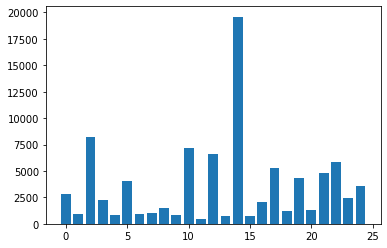

In [87]:
# what are scores for the features
for i in range(len(fs.scores_)):
    print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

In [88]:
for i in range(len(fs.scores_)):
    print(f'Feature {aki_pos.columns[i]}: {fs.scores_[i]}')

Feature ADMIT_AGE: 2795.7897699924742
Feature #ADMISSIONS: 939.1786930588553
Feature CANCER_FLAG: 8179.463642901172
Feature KIDNEY_FAILURE_FLAG: 2276.736756645564
Feature HYPO_FLAG: 829.0717265388307
Feature SHOCK_FLAG: 4056.851666900953
Feature ANEMIA_FLAG: 920.0035046861765
Feature HEMO_FLAG: 1029.0000611888765
Feature ACID_FLAG: 1487.0539609419548
Feature LIVER_FLAG: 828.1318284771594
Feature HYPER_FLAG: 7129.425109651546
Feature VALUENUM: 501.2989512040052
Feature VALUE: 6573.807670728343
Feature GENDER_F: 767.6410252604878
Feature GENDER_M: 19599.632387837108
Feature ETHNICITY_AMERICAN INDIAN/ALASKA NATIVE: 752.9368307355458
Feature ETHNICITY_ASIAN: 2100.1412332377536
Feature ETHNICITY_ASIAN - ASIAN INDIAN: 5258.659736049213
Feature ETHNICITY_ASIAN - CAMBODIAN: 1217.2603294611865
Feature ETHNICITY_ASIAN - CHINESE: 4373.844866355705
Feature ETHNICITY_ASIAN - FILIPINO: 1322.3537116080379
Feature ETHNICITY_ASIAN - KOREAN: 4850.117732086944
Feature ETHNICITY_ASIAN - OTHER: 5886.944502

In [89]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
import numpy
# fix random seed for reproducibility
numpy.random.seed(0)

In [90]:
model = Sequential()

model.add(Dense(80, input_shape=(25,), kernel_regularizer=regularizers.l2(0.01), activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(60, activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(40, activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(20, activation = 'relu'))
model.add(Dropout(0.2))


model.add(Dense(1, activation = 'sigmoid'))

In [91]:
# Compile model
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [92]:
early_stopping_monitor = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=0,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

In [93]:
model.fit(X_train, y_train, batch_size=100, epochs=20, verbose=1, validation_data=(X_test, y_test), shuffle=True)

Train on 137517 samples, validate on 34380 samples
Epoch 1/20
137517/137517 [==============================] - 7s 51us/step - loss: 0.4027 - accuracy: 0.8029 - val_loss: 0.3457 - val_accuracy: 0.8287
Epoch 2/20
137517/137517 [==============================] - 6s 44us/step - loss: 0.3427 - accuracy: 0.8301 - val_loss: 0.3256 - val_accuracy: 0.8413
Epoch 3/20
137517/137517 [==============================] - 6s 44us/step - loss: 0.3274 - accuracy: 0.8408 - val_loss: 0.3053 - val_accuracy: 0.8608
Epoch 4/20
137517/137517 [==============================] - 6s 41us/step - loss: 0.3155 - accuracy: 0.8503 - val_loss: 0.2944 - val_accuracy: 0.8556
Epoch 5/20
137517/137517 [==============================] - 6s 40us/step - loss: 0.3076 - accuracy: 0.8546 - val_loss: 0.2869 - val_accuracy: 0.8656
Epoch 6/20
137517/137517 [==============================] - 5s 39us/step - loss: 0.3033 - accuracy: 0.8556 - val_loss: 0.2802 - val_accuracy: 0.8690
Epoch 7/20
137517/137517 [=============================

In [49]:
# estimate accuracy on test data set
scores = model.evaluate(X_test, y_test, verbose=0)
print("Just 5 features, " "%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Just 5 features, accuracy: 77.81%


In [94]:
# estimate accuracy on test data set
scores = model.evaluate(X_test, y_test, verbose=0)
print("25 features, " "%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

25 features, accuracy: 88.12%


In [64]:
# estimate accuracy on test data set
scores = model.evaluate(X_test, y_test, verbose=0)
print("All 105 features, " "%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

All 105 features, accuracy: 90.35%
